# Projet de fin de majeure : Super résolution
#### Johanna Dubos, Zoé Ducourau & Dimitri Szezurek
---

In [160]:
# Librairies
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import shutil
import itk

In [226]:
def decimation(input_img, ds_rate):
    down_sampled_img = np.zeros([int(np.shape(input_img)[0]/ds_rate), int(np.shape(input_img)[1]/ds_rate)])
    for i in range(np.shape(input_img)[0]):
        for j in range(np.shape(input_img)[1]):
            i_ds = int(i/ds_rate)
            j_ds = int(j/ds_rate)
            if i % ds_rate == 0 and j % ds_rate == 0 :
                down_sampled_img[i_ds, j_ds] = input_img[i, j]
        
    return down_sampled_img

def interpolation(input_img, us_rate):
    up_sampled_img = np.zeros([np.shape(input_img)[0]*us_rate, np.shape(input_img)[1]*us_rate])
    for i in range(np.shape(input_img)[0]):
        for j in range(np.shape(input_img)[1]):
            up_sampled_img[i*us_rate, j*us_rate] = input_img[i, j]
        
    return up_sampled_img

#### Image considérée (échelle de Monoyer)

Taille de l'image : Hauteur =  512 || Largeur =  512


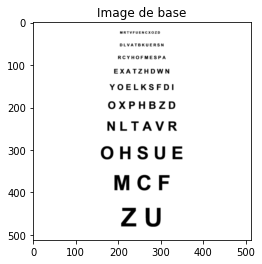

In [214]:
filename = 'Monoyer-square.png'

IMAGE_nb = cv2.imread(filename,0)
IMAGE_nb = cv2.pyrDown(IMAGE_nb)
[H,W] = IMAGE_nb.shape

print("Taille de l'image : Hauteur = ", H, "|| Largeur = " , W)

plt.imshow(IMAGE_nb,cmap='gray')
plt.title('Image de base')
plt.show()

#### Création de la BDD avec N images (déformées, floutées, sous-échantillonées & bruitées)

In [215]:
if os.path.exists('BDD'):
    shutil.rmtree('BDD')

os.makedirs('BDD')

In [242]:
sampling_rate = 2
noyau = 1/16*np.array([[1,2,1],[2,4,2],[1,2,1]])

In [243]:
N = 10 # Nb d'images dans la BDD

for i in range (0,N):

    if i == 0:
        img_blurred = cv2.filter2D(src=IMAGE_nb, ddepth=-1, kernel=noyau) # Floutage
        img_downsampled = decimation(img_blurred, sampling_rate) # Sous-échantillonnage /4

        # Ajout d'un bruit gaussien 
        gauss = np.random.normal(0,5,img_downsampled.shape)
        gauss = gauss.reshape(img_downsampled.shape)
        img_noisy = img_downsampled + gauss

        plt.imsave("BDD/imageBR_0.png",img_noisy,cmap='gray')

    else:
        t_max = 50
        angle=np.random.randint(-10,10)
        rotation = cv2.getRotationMatrix2D((W/2,H/2), angle, 1) # Matrice de rotation
        translation =[np.random.uniform(-t_max,t_max), np.random.uniform(-t_max,t_max)]
        rigid = rotation
        rigid[0,2] += translation[0]
        rigid[1,2] += translation[1]
        img_transformed = cv2.warpAffine(IMAGE_nb, rigid, (W,H), borderMode=cv2.BORDER_REPLICATE) # Rotation + translation
        img_blurred = cv2.filter2D(src=img_transformed, ddepth=-1, kernel=noyau) # Floutage 
        img_downsampled = decimation(img_blurred, sampling_rate) # Sous-échantillonnage /4

        # Ajout d'un bruit gaussien 
        gauss = np.random.normal(0,5,img_downsampled.shape)
        gauss = gauss.reshape(img_downsampled.shape)
        img_noisy = img_downsampled + gauss

        plt.imsave("BDD/imageBR_"+str(i)+".png",img_noisy,cmap='gray')
        
[H_LR, W_LR] = img_noisy.shape

#### Différentes étapes :
- Recalage/estimation du mouvement des images BR
- Estimation du flou des images BR
- Sélection d'un a priori convenable
- Estimation d'une image HR


## Recalage des images de la BDD

In [244]:
def get_transformation(fixed_img, moving_img):


    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(moving_img, None)
    kp2, des2 = orb.detectAndCompute(fixed_img, None)

    # Affichage des points d'intérêt
    # base_keypoints = cv2.drawKeypoints(fixed_img, kp2, color=(0, 0, 255), flags=0, outImage=fixed_img)
    # test_keypoints = cv2.drawKeypoints(moving_img, kp1, color=(0, 0, 255), flags=0, outImage=moving_img)

    # Création de l'objet BFMatcher et recherche des correspondances
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    # Tri des correspondances selon leur distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Extraction des meilleures correspondances
    num_matches = 1000
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches[:num_matches]]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches[:num_matches]]).reshape(-1, 1, 2)

    # Calcul de l'homographie et recale de l'image 1 sur l'image 2
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    return M




In [245]:
N_registration = 4 # Nombre d'images à recaler (inferieur strictement à N)

list_M = [] # Liste des matrices de transformation

fixed_img_itk = itk.imread('BDD/imageBR_0.png', itk.UC)

optimizer = itk.RegularStepGradientDescentOptimizer.New() # Instance de la classe d'optimiseur choisie
optimizer.SetMaximumStepLength(0.01) # Borne supérieure du pas de descente (en pixel)
optimizer.SetMinimumStepLength(0.01) # Borne inférieure du pas de descente (en pixel)
optimizer.SetNumberOfIterations(5000) # Nombre maximal d'itération
scales= [180/np.pi,0.5,0.5,0.5,0.5]
optimizer.SetScales(scales) # Nombre maximal d'itération
 
f=[]
def getMetricValue():
    f.append(optimizer.GetValue())

optimizer.AddObserver(itk.IterationEvent(), getMetricValue)

for i in range(1, N_registration + 1):  
    
    print('BDD/imageBR_' + str(i) + '.png')      
    moving_img_itk = itk.imread('BDD/imageBR_' + str(i) + '.png', itk.UC)
    
    initialTransform = itk.CenteredRigid2DTransform[itk.D].New() #transformation rigide
    initialParameters = initialTransform.GetParameters() #paramètres de la transformation
    initialParameters[0] = 0 #angle
    initialParameters[1] = H_LR/2 #centre de rotation
    initialParameters[2] = W_LR/2 #centre de rotation
    initialParameters[3] = 0 #tx
    initialParameters[4] = 0 #ty
    
    interpolator = itk.LinearInterpolateImageFunction[type(moving_img_itk), itk.D].New() 
    metric = itk.MeanSquaresImageToImageMetric[type(fixed_img_itk), type(moving_img_itk)].New()

    registration_filter = itk.ImageRegistrationMethod[type(fixed_img_itk), type(moving_img_itk)].New() # Instance de la classe de recalage
    registration_filter.SetFixedImage(fixed_img_itk) # Image de référence
    registration_filter.SetMovingImage(moving_img_itk) # Image à recaler
    registration_filter.SetOptimizer(optimizer) # Optimiseur
    registration_filter.SetTransform(initialTransform)  # Transformation
    registration_filter.SetInitialTransformParameters(initialParameters) #Application de la transformation initiale
    registration_filter.SetInterpolator(interpolator) # Interpolateur
    registration_filter.SetMetric(metric) # Métrique
    registration_filter.Update() # Exécution du recalage
    transform = registration_filter.GetTransform()
    
       
    print(transform)
    
    list_M.append(transform)

BDD/imageBR_1.png
CenteredRigid2DTransform (0x1c7dbba0)
  RTTI typeinfo:   itk::CenteredRigid2DTransform<double>
  Reference Count: 5
  Modified Time: 32109
  Debug: Off
  Object Name: 
  Observers: 
    none
  Matrix: 
    0.999998 0.00184675 
    -0.00184675 0.999998 
  Offset: [-0.237786, 0.285443]
  Center: [128, 128]
  Translation: [-0.00162042, 0.048841]
  Inverse: 
    0.999998 -0.00184675 
    0.00184675 0.999998 
  Singular: 0
  Angle       = -0.00184675

BDD/imageBR_2.png
CenteredRigid2DTransform (0x1c217f20)
  RTTI typeinfo:   itk::CenteredRigid2DTransform<double>
  Reference Count: 5
  Modified Time: 54544
  Debug: Off
  Object Name: 
  Observers: 
    none
  Matrix: 
    0.983546 -0.180656 
    0.180656 0.983546 
  Offset: [28.1313, -19.6737]
  Center: [127.843, 128.466]
  Translation: [2.81969, 1.30812]
  Inverse: 
    0.983546 0.180656 
    -0.180656 0.983546 
  Singular: 0
  Angle       = 0.181654

BDD/imageBR_3.png
CenteredRigid2DTransform (0x1e8c7420)
  RTTI typeinfo:

BDD/imageBR_1.png
BDD/imageBR_2.png
BDD/imageBR_3.png
BDD/imageBR_4.png


(-0.5, 255.5, 255.5, -0.5)

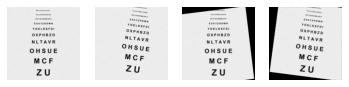

In [258]:
N_registration = 4 # Nombre d'images à recaler (inferieur strictement à N)

list_M = [] # Liste

fixed_img = cv2.imread('BDD/imageBR_0.png')
for i in range(1, N_registration + 1):  
    print('BDD/imageBR_' + str(i) + '.png')  
    moving_img = cv2.imread('BDD/imageBR_' + str(i) + '.png')
    list_M.append(get_transformation(fixed_img, moving_img))


M = get_transformation(fixed_img, moving_img)
registered_img = cv2.warpPerspective(moving_img, M, (fixed_img.shape[1], fixed_img.shape[0]))

unregistered_img = cv2.warpPerspective(registered_img, M, (moving_img.shape[1], moving_img.shape[0]), flags = cv2.WARP_INVERSE_MAP)

plt.subplot(141)
plt.imshow(fixed_img, cmap='gray')
plt.axis('off')

plt.subplot(142)
plt.imshow(moving_img, cmap='gray')
plt.axis('off')

plt.subplot(143)
plt.imshow(registered_img, cmap='gray')
plt.axis('off')

plt.subplot(144)
plt.imshow(unregistered_img, cmap='gray')
plt.axis('off')

## Descente de gradient

Text(0.5, 1.0, 'Estimation de départ')

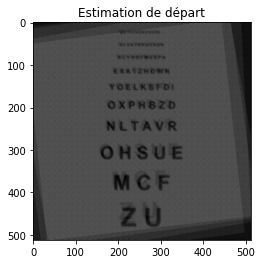

In [267]:

# initialisation
estim_0 = interpolation(cv2.imread('BDD/imageBR_0.png', 0), sampling_rate)
observations = []
for k in range(N_registration):
    observations.append(cv2.imread('BDD/imageBR_' + str(k+1) + '.png', 0))
    transfo = list_M[k].copy()
    transfo[0][2] *= sampling_rate
    transfo[1][2] *= sampling_rate
    estim_0 += cv2.warpPerspective(interpolation(observations[k], sampling_rate), transfo, [H,W])
    
    


# estim_0 = cv2.resize(observations[0], dim_HR, interpolation = cv2.INTER_CUBIC)
# estim_0 = interpolation(observations[0], sampling_rate)

plt.figure()
plt.imshow(estim_0, cmap="gray")
plt.title('Estimation de départ')

Text(0.5, 1.0, 'Estimation finale')

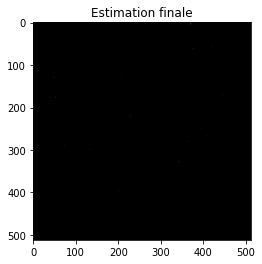

In [273]:
# paramètres
beta = 1
l = 0
alpha = 0.6
P = 1

estim = estim_0
erreur = []
# iterations
CA = False
n_iter = 0
while CA == False:

    # gradient
    gradient = np.zeros([H,W])
    for k in range(N_registration):
        # appliquer la transfo (rotation + translation) à l'estimation
        transfo = list_M[k][0:2].copy()
        transfo[0][2] *= sampling_rate
        transfo[1][2] *= sampling_rate
        estim_recal = cv2.warpAffine(estim, transfo, [H,W], flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_REPLICATE) # Rotation + translation
        # convoluer PSF (flou blanc gaussien)
        estim_recal_psf =cv2.filter2D(src=estim_recal, ddepth=-1, kernel=noyau)
        # down sampling 
        estim_recal_psf_ds = decimation(estim_recal_psf, sampling_rate) # Sous-échantillonnage /4
        # soustaire l'observation
        diff = estim_recal_psf_ds - observations[k] 
        # opérateur signe 
        sign = np.sign(diff)
        # up sampling
        estim_us = interpolation(sign, sampling_rate)
        # convoluer par T(PSF)
        estim_us_psf = cv2.filter2D(src=estim_us, ddepth=-1, kernel=noyau) # le noyau est symétrique donc T(PSF)=PSF
        # appliquer transfo inverse
        estim_us_psf_recale = cv2.warpAffine(estim_us_psf, transfo, [H,W], borderMode=cv2.BORDER_REPLICATE) # Rotation + translation
        # somme des gradients
        gradient += estim_us_psf_recale
        
    # pas de régularisation
    regul = 0
    
    
    # régularisation Tikhonov
    kernel_laplacien = 1/8*np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])
    r = cv2.filter2D(src=estim, ddepth=-1, kernel=kernel_laplacien)
    regul = (r**2)
    
    
    """
    # régularisation shift & add
    regul = np.zeros(dim_HR)
    for l in range(-P, P+1):
        for m in range(0, P+1):
            if l+m >= 0:
                # appliquer shift Sx et Sy à l'estimation
                Sxy = np.float32([[1, 0, m], [0, 1, l]])
                img_translation = cv2.warpAffine(estim, Sxy, dim_HR, borderMode=cv2.BORDER_REPLICATE)
                
                # soustraire le résultat à l'estimation 
                diff = estim - img_translation
                # appliquer opérateur signe
                sign = np.sign(diff)
                
                # appliquer anti shift Sx-1 et Sy-1
                Sxy_inv = np.float32([[1, 0, -m], [0, 1, -l]])
                img_translation_2 = cv2.warpAffine(sign, Sxy_inv, dim_HR, borderMode=cv2.BORDER_REPLICATE)
                # soustraire au résultat intermédiaire
                
                diff = (np.identity(dim_HR[0]) - img_translation_2) * sign
                # multiplier par alpha ^{|m|+|l|}
                r_lm = (alpha ** (abs(m)+abs(l)))*diff
                # sommation
                regul += r_lm
    """
    
            
    
    step = gradient + l*regul
    new_estim = np.abs(estim - beta*step)
    estim = new_estim
    erreur.append(np.mean(np.sqrt((IMAGE_nb - new_estim)**2)))
    
    n_iter += 1
    if len(erreur) > 2:
        if erreur[-2] < erreur[-1]:
            CA = True
        if abs(erreur[-2] - erreur[-1]) < 0.001:
            CA = True
    if n_iter > 30:
        CA = True
    
       
plt.figure()
plt.imshow(new_estim, cmap='gray')
plt.title("Estimation finale")
    


descente de gradient : 109.08078837275482
interpolation de départ : 120.92906814068556


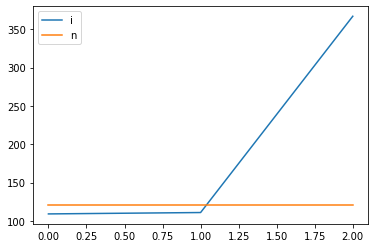

In [274]:
plt.figure()
plt.plot(range(len(erreur)), erreur, range(len(erreur)), np.ones(len(erreur))*np.mean(np.sqrt((IMAGE_nb - estim_0)**2)))
plt.legend("descente de gradient")
plt.legend("interpolation bicubique")

print("descente de gradient : " + str(min(erreur)))
print("interpolation de départ : " + str(np.mean(np.sqrt((IMAGE_nb - estim_0)**2))))


In [262]:
plt.imsave("estimationHR" + str(N_registration) + ".png",new_estim,cmap='gray')

In [203]:
np.max(estim_0)

255.0